In [ ]:
pip install torch_geometric

In [ ]:
pip install torch torchvision torchaudio

In [1]:
import os
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import global_add_pool
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdchem

물리 상수 및 설정

In [2]:
# 결합 해리 에너지 (kcal/mol)
BDE_TABLE = {
    (1, 1): 104, (1, 6): 99,  (1, 7): 93,  (1, 8): 111, (1, 9): 135,
    (6, 6): 83,  (6, 7): 73,  (6, 8): 86,  (6, 9): 116,
    (7, 7): 39,  (7, 8): 53,  (8, 8): 35
}

# 원자 물리 속성 [EN, Hardness, Radius, IE]
ATOM_PROPS_TABLE = {
    1: [2.20, 6.42, 0.31, 13.60],  # H
    6: [2.55, 5.00, 0.76, 11.26],  # C
    7: [3.04, 7.27, 0.71, 14.53],  # N
    8: [3.44, 6.08, 0.66, 13.62],  # O
    9: [3.98, 7.01, 0.57, 17.42]   # F
}
DEFAULT_PROPS = [0.0, 0.0, 0.0, 0.0]

# H5 파일 키 설정
KEY_CONFIG = {
    "atoms": "elements", 
    "smiles": "Rsmiles",
    "R_coords": "RG", "TS_coords": "TSG", "P_coords": "PG",          
    "R_energy": { "H": "R_H", "G": "R_F", "E": "R_E" },
    "TS_energy": { "H": "TS_H", "G": "TS_F", "E": "TS_E" },
    "P_energy": { "H": "P_H", "G": "P_F", "E": "P_E" }
}

# 주요 작용기 SMARTS 패턴
FUNCTIONAL_GROUPS = {
    # --- EWG (Electron Withdrawing Groups) ---
    "Nitro": "[N+](=O)[O-]",          # 강한 EWG
    "Sulfonyl": "S(=O)(=O)",          # 강한 EWG
    "Cyano": "C#N",                   # 강한 EWG
    "Trifluoromethyl": "C(F)(F)F",    # 강한 EWG (Inductive)
    "Carbonyl": "[CX3]=[OX1]",        # 중간 EWG (Ketone, Aldehyde, Ester...)
    "Carboxyl": "[CX3](=O)[OX2H1]",   # 중간 EWG
    "Halogen": "[F,Cl,Br,I]",         # 약한 EWG (Inductive), 약한 EDG (Resonance)

    # --- EDG (Electron Donating Groups) ---
    "Amine": "[NX3;H2,H1,H0;!$(NC=O)]", # 강한 EDG (Not Amide)
    "Hydroxy": "[OX2H]",                # 강한 EDG
    "Alkoxy": "[OX2][CX4]",             # 강한 EDG (Ether)
    "Amide": "[NX3][CX3](=O)",          # 약한 EDG (Resonance) / EWG (Inductive)
    "Alkyl": "[CX4]",                   # 약한 EDG (Inductive)
    "Phenyl": "c1ccccc1"                # 공명 효과 (Resonance)
}

# 작용기 성격 매핑 (1: EDG, -1: EWG, 0: Neutral/Mixed)
# 이 값은 초기 가중치로 사용되거나 Feature로 들어갑니다.
FG_TYPE_MAP = {
    "Nitro": -1.0, "Sulfonyl": -1.0, "Cyano": -1.0, "Trifluoromethyl": -1.0,
    "Carbonyl": -0.5, "Carboxyl": -0.5, "Halogen": -0.2,
    "Amine": 1.0, "Hydroxy": 1.0, "Alkoxy": 1.0, "Amide": 0.2, "Alkyl": 0.3, "Phenyl": 0.1
}

# 작용기 개수 (One-hot Encoding용)
NUM_FG_TYPES = len(FUNCTIONAL_GROUPS)

데이터셋

In [3]:
class RDKitHessDataset(Dataset):
    def __init__(self, h5_path, limit=None):
        super(RDKitHessDataset, self).__init__(None, transform=None, pre_transform=None)
        self.h5_path = h5_path
        if not os.path.exists(h5_path): 
            raise FileNotFoundError(f"File not found: {h5_path}")
            
        with h5py.File(self.h5_path, 'r') as f:
            self.keys = list(f.keys())
            if limit: self.keys = self.keys[:limit]
            self.len_data = len(self.keys)
            
        # SMARTS 패턴 미리 컴파일 (속도 향상)
        self.fg_patterns = {name: Chem.MolFromSmarts(smarts) for name, smarts in FUNCTIONAL_GROUPS.items()}

    def len(self): return self.len_data

    def get_rdkit_atom_features(self, mol):
        # 1. Gasteiger Charge 계산
        try: AllChem.ComputeGasteigerCharges(mol)
        except: pass

        features = []
        hsab_list = []

        # Atom Map 정렬
        atoms_with_map = []
        for atom in mol.GetAtoms():
            map_num = atom.GetAtomMapNum()
            if map_num == 0: map_num = atom.GetIdx() + 1
            atoms_with_map.append((map_num, atom))
        atoms_with_map.sort(key=lambda x: x[0])
        
        # [New] 작용기 매칭 수행
        # 각 원자가 어떤 작용기에 속하는지 마킹
        atom_fg_info = {atom.GetIdx(): {'ewg': 0.0, 'edg': 0.0, 'types': []} for atom in mol.GetAtoms()}
        
        for name, pattern in self.fg_patterns.items():
            if pattern:
                matches = mol.GetSubstructMatches(pattern)
                effect = FG_TYPE_MAP.get(name, 0.0)
                for match in matches:
                    for atom_idx in match:
                        # EWG/EDG 점수 누적
                        if effect < 0: atom_fg_info[atom_idx]['ewg'] += abs(effect)
                        elif effect > 0: atom_fg_info[atom_idx]['edg'] += effect
                        atom_fg_info[atom_idx]['types'].append(name)

        for _, atom in atoms_with_map:
            feat = []
            z = atom.GetAtomicNum()
            idx = atom.GetIdx()
            
            # [1] Symbol (6)
            sym_map = {'H':0, 'C':1, 'N':2, 'O':3, 'F':4}; one_hot=[0]*6; one_hot[sym_map.get(atom.GetSymbol(),5)]=1
            feat.extend(one_hot)
            
            # [2] Hyb (5)
            hyb=atom.GetHybridization(); hyb_map={rdchem.HybridizationType.SP:0, rdchem.HybridizationType.SP2:1, rdchem.HybridizationType.SP3:2, rdchem.HybridizationType.SP3D:3, rdchem.HybridizationType.SP3D2:4}
            hyb_vec=[0]*5; 
            if hyb in hyb_map: hyb_vec[hyb_map[hyb]]=1
            feat.extend(hyb_vec)
            
            # [3] Elec & Mass (4)
            try: q=float(atom.GetProp('_GasteigerCharge'))
            except: q=0.0
            if np.isnan(q): q=0.0
            feat.extend([q, float(atom.GetFormalCharge()), float(atom.GetTotalValence()), atom.GetMass()/20.0])
            
            # [4] Topology (4) & Arom/Chiral (2)
            feat.extend([1.0 if atom.IsInRingSize(s) else 0.0 for s in [3,4,5,6]])
            feat.extend([1.0 if atom.GetIsAromatic() else 0.0, 1.0 if atom.GetChiralTag()!=rdchem.ChiralType.CHI_UNSPECIFIED else 0.0])
            
            # [5] [New] Functional Group Features (6 dims)
            # EWG Score, EDG Score, Is_Nitro/Sulfonyl, Is_Carbonyl, Is_Amine/Hydroxy, Is_Halogen
            info = atom_fg_info[idx]
            fg_vec = [
                info['ewg'], # EWG 강도
                info['edg'], # EDG 강도
                1.0 if 'Nitro' in info['types'] or 'Sulfonyl' in info['types'] else 0.0,
                1.0 if 'Carbonyl' in info['types'] else 0.0,
                1.0 if 'Amine' in info['types'] or 'Hydroxy' in info['types'] else 0.0,
                1.0 if 'Halogen' in info['types'] else 0.0
            ]
            feat.extend(fg_vec)
            
            features.append(feat) # Total Dim: 6+5+4+4+2+6 = 27
            
            # HSAB
            props = ATOM_PROPS_TABLE.get(z, DEFAULT_PROPS)
            hsab_list.append([-props[0], props[1]])
            
        return torch.tensor(features, dtype=torch.float), torch.tensor(hsab_list, dtype=torch.float)

    def get(self, idx):
        # (기존 코드와 동일, get_rdkit_atom_features 호출 부분만 자동으로 변경됨)
        with h5py.File(self.h5_path, 'r') as f:
            group = f[self.keys[idx]]
            if KEY_CONFIG["smiles"] in group:
                smi = group[KEY_CONFIG["smiles"]][()]; smi = smi.decode('utf-8') if isinstance(smi, bytes) else str(smi)
                mol = Chem.MolFromSmiles(smi)
                if mol: mol = Chem.AddHs(mol); x, hsab = self.get_rdkit_atom_features(mol)
                else: 
                    atoms = group[KEY_CONFIG["atoms"]][()]
                    # Fallback 시 차원 27로 증가
                    x = torch.zeros(len(atoms), 27); hsab = torch.zeros(len(atoms), 2)
            else: 
                atoms = group[KEY_CONFIG["atoms"]][()]
                x = torch.zeros(len(atoms), 27); hsab = torch.zeros(len(atoms), 2)

            pos_R = torch.tensor(group[KEY_CONFIG["R_coords"]][()], dtype=torch.float)
            pos_TS = torch.tensor(group[KEY_CONFIG["TS_coords"]][()], dtype=torch.float)
            pos_P = torch.tensor(group[KEY_CONFIG["P_coords"]][()], dtype=torch.float)
            
            e_R = torch.tensor([group[KEY_CONFIG["R_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_TS = torch.tensor([group[KEY_CONFIG["TS_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_P = torch.tensor([group[KEY_CONFIG["P_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            
            y_fwd = (e_TS - e_R).unsqueeze(0); y_rev = (e_TS - e_P).unsqueeze(0); thermo = (e_P - e_R).unsqueeze(0)
            y_pos = pos_TS

            if x.size(0)!=pos_R.size(0): m=min(x.size(0),pos_R.size(0)); x=x[:m]; hsab=hsab[:m]; pos_R=pos_R[:m]; pos_P=pos_P[:m]; pos_TS=pos_TS[:m]
            
            n=x.size(0); r=torch.arange(n).repeat_interleave(n); c=torch.arange(n).repeat(n); mask=r!=c
            edge_index=torch.stack([r[mask], c[mask]], dim=0)
            
            sym=torch.argmax(x[:,:6], dim=1); map_z={0:1,1:6,2:7,3:8,4:9,5:0}
            z=torch.tensor([map_z.get(i.item(),0) for i in sym], dtype=torch.long)
            bde = [BDE_TABLE.get(tuple(sorted((int(z[i]), int(z[j])))), 80.0) for i,j in edge_index.T]
            edge_bde = torch.tensor(bde, dtype=torch.float).unsqueeze(-1)

            return Data(x=x, z=z, hsab=hsab, pos=pos_R, pos_P=pos_P, edge_index=edge_index,
                        y_fwd=y_fwd, y_rev=y_rev, y_pos=y_pos, thermo_energy=thermo, edge_bde=edge_bde)

물리 레이어 모듈

In [4]:
class PaulingBondLayer(nn.Module):
    """ 폴링 결합 차수: 거리 기반 결합 강도 추정 """
    def __init__(self):
        super().__init__()
        self.r0_table = torch.tensor([0.0, 0.31, 0.0, 0.0, 0.0, 0.0, 0.76, 0.71, 0.66, 0.57]) 
    def forward(self, z, edge_index, dist):
        row, col = edge_index
        r0_i = self.r0_table.to(z.device)[z[row]]
        r0_j = self.r0_table.to(z.device)[z[col]]
        r0_sum = (r0_i + r0_j).unsqueeze(-1)
        return torch.exp((r0_sum - dist) / 0.3)

In [5]:
class StereoelectronicLayer(nn.Module):
    """ 궤도 정렬 효과: 반응물과 생성물 간의 결합 각도 변화 감지 """
    def __init__(self): super().__init__()
    def forward(self, pos_R, pos_P, edge_index):
        row, col = edge_index
        vec_R = F.normalize(pos_R[col] - pos_R[row], p=2, dim=-1)
        vec_P = F.normalize(pos_P[col] - pos_P[row], p=2, dim=-1)
        # 내적(Cosine Similarity) -> 1.0(유지) ~ -1.0(반전/SN2)
        return (vec_R * vec_P).sum(dim=-1, keepdim=True)

In [6]:
class ElectrostaticsLayer(nn.Module):
    """ 정전기적 상호작용 (쿨롱 법칙): RDKit Charge 사용 """
    def __init__(self): super().__init__()
    def forward(self, charge, edge_index, dist):
        row, col = edge_index
        q_i = charge[row]
        q_j = charge[col]
        # E = q1 * q2 / r
        return (q_i * q_j) / (dist + 0.1)

In [7]:
class SolvationLayer(nn.Module):
    """ 용매 효과 (Born Solvation): 전하 분리 안정화 """
    def __init__(self): super().__init__()
    def forward(self, h, batch):
        mol_feat = global_add_pool(h, batch)
        # 분자의 전체적인 전하 분포 크기(Norm)가 클수록 용매 안정화 효과 큼
        effective_q2 = torch.norm(mol_feat, dim=-1, keepdim=True) ** 2
        mol_size = global_add_pool(torch.ones_like(batch, dtype=torch.float).unsqueeze(-1), batch)
        return -1.0 * (effective_q2 / (mol_size + 1.0))

In [8]:
class HammondGate(nn.Module):
    """ 해먼드 가설: 반응열(Thermo)에 따른 TS 위치(Late/Early) 추론 """
    def __init__(self):
        super().__init__()
        self.gate = nn.Sequential(
            nn.Linear(3, 16), nn.SiLU(),
            nn.Linear(16, 1), nn.Sigmoid()
        )
    def forward(self, thermo):
        return self.gate(thermo)

In [9]:
class HOMALayer(nn.Module):
    """
    결합 길이의 편차를 이용하여 국소적 방향족성을 정량화
    HOMA = 1 - alpha * sum( (R_opt - R_i)^2 )
    """
    def __init__(self):
        super().__init__()
        # C-C 결합 기준 상수 (Benzene-like)
        self.cc_opt = 1.388
        self.cc_alpha = 257.7
        
    def forward(self, z, edge_index, dist):
        row, col = edge_index
        # 탄소-탄소 결합(C-C)인지 확인
        is_cc = (z[row] == 6) & (z[col] == 6)
        
        diff = dist - self.cc_opt
        penalty = self.cc_alpha * (diff ** 2)
        
        # C-C 결합인 경우에만 HOMA 계산, 나머지는 0
        homa_contrib = torch.where(is_cc.unsqueeze(-1), 1.0 - penalty, torch.zeros_like(dist))
        
        # 값 클리핑 (-1 ~ 1)
        return torch.clamp(homa_contrib, -1.0, 1.0)

In [10]:
class HSABInteractionLayer(nn.Module):
    """
    화학적 포텐셜(mu) 차이와 경도(eta) 합을 이용한 에너지 갭 계산
    Delta E ~ (mu_A - mu_B)^2 / (eta_A + eta_B)
    """
    def __init__(self):
        super().__init__()

    def forward(self, hsab, edge_index):
        # hsab: [N, 2] 텐서 (col 0: mu, col 1: eta)
        mu = hsab[:, 0]
        eta = hsab[:, 1]
        
        row, col = edge_index
        
        # 1. Chemical Potential Diff (Electrophilicity mismatch)
        d_mu = (mu[row] - mu[col]).pow(2)
        
        # 2. Hardness Sum (Resistance)
        sum_eta = eta[row] + eta[col]
        
        # Klopman-Salem Term
        fmo_energy = d_mu / (sum_eta + 1e-6)
        
        return fmo_energy.unsqueeze(-1) # (E, 1)

In [11]:
class StericLayer(nn.Module):
    """
    원자 주변의 입체적 밀집도(Density) 계산
    """
    def __init__(self): 
        super().__init__()
        
    def forward(self, pos, edge_index):
        row, col = edge_index
        # 거리의 역제곱으로 밀도 근사
        dist = (pos[row] - pos[col]).norm(dim=-1)
        density = 1.0 / (dist.pow(2) + 0.1)
        
        # 노드별로 밀도 합산 (Node Feature)
        steric_score = torch.zeros(pos.size(0), 1, device=pos.device)
        steric_score.index_add_(0, row, density.unsqueeze(-1))
        
        return steric_score

In [12]:
class FunctionalGroupLayer(nn.Module):
    """
    [New] 작용기 상호작용 레이어 (Functional Group Interaction)
    분자 내 EWG/EDG의 분포를 파악하여 반응 중심에 미치는 전자적 영향을 집계합니다.
    """
    def __init__(self, hidden_dim):
        super().__init__()
        # EWG/EDG 정보를 처리하는 전용 MLP
        self.fg_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        # 어텐션 메커니즘: 어떤 작용기가 반응에 가장 큰 영향을 주는지 학습
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, h, batch):
        # h: Node Features [N, Hidden] (여기에는 이미 FG 정보가 인코딩되어 있음)
        
        # 1. 작용기 특성 변환
        fg_feat = self.fg_mlp(h)
        
        # 2. 중요도 가중치 (Attention)
        # 반응 중심이나 강력한 작용기(Nitro 등)에 더 높은 가중치 부여
        weights = self.attention(fg_feat)
        weighted_feat = fg_feat * weights
        
        # 3. 분자 전체의 전자적 환경(Electronic Context) 집계
        # (Global Add Pooling)
        global_electronic_context = global_add_pool(weighted_feat, batch)
        
        return global_electronic_context

GNN backbone

In [13]:
class DeepGCPNet(nn.Module):
    def __init__(self, node_dim, hidden_dim, num_layers=4):
        super().__init__()
        self.embedding = nn.Linear(node_dim, hidden_dim)
        self.layers = nn.ModuleList([DeepGCPLayer(hidden_dim) for _ in range(num_layers)])
    def forward(self, x, pos, edge_index):
        h = self.embedding(x)
        for layer in self.layers: h = layer(h, pos, edge_index)
        return h

In [14]:
class DeepGCPLayer(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.message_mlp = nn.Sequential(nn.Linear(hidden_dim*2+1, hidden_dim), nn.SiLU(), nn.Dropout(dropout), nn.Linear(hidden_dim, hidden_dim))
        self.update_mlp = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim), nn.SiLU(), nn.Dropout(dropout), nn.Linear(hidden_dim, hidden_dim))
        self.norm = nn.LayerNorm(hidden_dim)
    def forward(self, h, pos, edge_index):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        edge_feat = torch.cat([h[row], h[col], dist], dim=-1)
        aggr_msg = torch.zeros_like(h)
        aggr_msg.index_add_(0, row, self.message_mlp(edge_feat))
        return self.norm(h + self.update_mlp(torch.cat([h, aggr_msg], dim=-1)))

In [15]:
class SigmoidGating(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.gate_mlp = nn.Sequential(nn.Linear(hidden_dim*2+1, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, 1), nn.Sigmoid())
    def forward(self, h, edge_index, pos):
        row, col = edge_index; dist = (pos[row]-pos[col]).norm(dim=-1, keepdim=True)
        return self.gate_mlp(torch.cat([h[row], h[col], dist], dim=-1))

In [16]:
class StructureDecoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, 1))
    def forward(self, h, edge_index, gate_score):
        row, col = edge_index
        return self.mlp(torch.cat([h[row], h[col]], dim=-1)) * gate_score

예측기

In [17]:
class HessHammondPredictor(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        # Physics Layers
        self.pauling = PaulingBondLayer()
        self.stereo = StereoelectronicLayer()
        self.hammond = HammondGate()
        self.electro = ElectrostaticsLayer()
        self.solvation = SolvationLayer()
        self.homa = HOMALayer()
        self.hsab = HSABInteractionLayer()
        self.steric = StericLayer()
        self.fg_layer = FunctionalGroupLayer(hidden_dim) # [New] 작용기 레이어
        
        # Node MLP (Base Energy)
        # Hidden + Thermo(3) + Solv(1) + Steric(1) + FG_Context(Hidden)
        # = Hidden*2 + 5
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 5, hidden_dim), 
            nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, 3)
        )
        
        # Edge MLP (Barrier Energy)
        # 2H + Dist_R(1) + Dist_P(1) + Gate(1) + BO(3) + BDE(1) + Align(1) + Hammond(1) + Coul(1) + HOMA(1) + HSAB(1) + Pred_D(1)
        # = 2H + 13
        edge_in = (hidden_dim * 2) + 13
        
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_in, hidden_dim), nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 6) # Fwd(3) + Rev(3)
        )

    def forward(self, h, z, charge, hsab, edge_index, pos_R, pos_P, gate_score, pred_delta_D, batch, thermo, bde):
        row, col = edge_index
        
        # 1. Hammond
        late_char = self.hammond(thermo) 
        late_char_edge = late_char[batch[row]]
        
        # 2. Node Physics & FG Interaction
        solv = self.solvation(h, batch)
        steric_R = self.steric(pos_R, edge_index)
        steric_graph = global_add_pool(steric_R, batch)
        
        # 작용기 문맥 추출
        fg_context = self.fg_layer(h, batch) 
        
        h_graph = global_add_pool(h, batch)
        
        # Base Energy Input Assemble
        base_input = torch.cat([h_graph, fg_context, thermo, solv, steric_graph], dim=-1)
        base = self.node_mlp(base_input)
        
        # 3. Edge Physics
        dist_R = (pos_R[row] - pos_R[col]).norm(dim=-1, keepdim=True)
        dist_P = (pos_P[row] - pos_P[col]).norm(dim=-1, keepdim=True)
        
        bo_R = self.pauling(z, edge_index, dist_R)
        bo_P = self.pauling(z, edge_index, dist_P)
        bo_TS = (1.0 - late_char_edge) * bo_R + late_char_edge * bo_P
        
        align = self.stereo(pos_R, pos_P, edge_index)
        coulomb = self.electro(charge, edge_index, dist_R)
        homa_R = self.homa(z, edge_index, dist_R)
        hsab_E = self.hsab(hsab, edge_index)
        
        # 4. Feature Assembly
        edge_feat = torch.cat([
            h[row], h[col],
            dist_R, dist_P,
            gate_score,
            bo_R, bo_P, bo_TS,
            bde, align, late_char_edge, coulomb,
            homa_R, hsab_E,
            pred_delta_D
        ], dim=-1)
        
        # 5. Predict
        edge_out = self.edge_mlp(edge_feat) * gate_score
        barriers = global_add_pool(edge_out, batch[row])
        
        pred_fwd = barriers[:, :3] + base
        pred_rev = barriers[:, 3:] + base
        
        return pred_fwd, pred_rev, late_char

모델

In [18]:
class RDKitHessModel(nn.Module):
    def __init__(self, node_dim=27, hidden_dim=256, num_layers=4):
        # [핵심] node_dim=27 (기본값)
        super().__init__()
        self.encoder = DeepGCPNet(node_dim, hidden_dim, num_layers)
        self.gating = SigmoidGating(hidden_dim)
        self.struct_decoder = StructureDecoder(hidden_dim)
        self.energy_predictor = HessHammondPredictor(hidden_dim)

    def forward(self, data):
        h = self.encoder(data.x, data.pos, data.edge_index)
        gate_map = self.gating(h, data.edge_index, data.pos)
        pred_delta_D = self.struct_decoder(h, data.edge_index, gate_map)
        
        # Charge: index 11
        charge = data.x[:, 11].unsqueeze(-1)
        
        pred_fwd, pred_rev, ts_char = self.energy_predictor(
            h, data.z, charge, data.hsab, data.edge_index, data.pos, data.pos_P,
            gate_map, pred_delta_D, data.batch, data.thermo_energy, data.edge_bde
        )
        
        return pred_delta_D, pred_fwd, pred_rev, gate_map, ts_char

학습루프

In [19]:
def train(h5_path, epochs=40, limit=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    
    # Dataset 로드 (여기서 x는 27차원으로 나옴)
    dataset = RDKitHessDataset(h5_path, limit=limit)
    
    print("Computing stats...")
    loader_stat = DataLoader(dataset, batch_size=128, shuffle=False)
    all_E = []
    HARTREE_TO_KCAL = 627.5
    for b in loader_stat:
        all_E.append(b.y_fwd.view(-1, 3) * HARTREE_TO_KCAL)
    all_E = torch.cat(all_E, dim=0)
    y_mean = all_E.mean(dim=0).to(device)
    y_std = all_E.std(dim=0).to(device)
    print(f"Stats (Fwd) -> Mean: {y_mean.cpu().numpy()}")

    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # [수정] node_dim=27을 명시적으로 전달하여 모델 생성
    model = RDKitHessModel(node_dim=27, hidden_dim=256, num_layers=4).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)
    
    history = {'loss': []}
    real_E3, pred_E3 = {'H':[], 'G':[], 'E':[]}, {'H':[], 'G':[], 'E':[]}
    
    print("\n[Start Hess & Hammond & FG Training]")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
        
        for batch in pbar:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            thermo_kcal = batch.thermo_energy.view(-1, 3) * HARTREE_TO_KCAL
            target_fwd = (batch.y_fwd.view(-1, 3) * HARTREE_TO_KCAL - y_mean) / y_std
            target_rev = (batch.y_rev.view(-1, 3) * HARTREE_TO_KCAL - (y_mean - thermo_kcal)) / y_std
            
            # Forward
            pred_d, pred_fwd, pred_rev, gate, ts_char = model(batch)
            
            # Loss Calculation
            dist_R = (batch.pos[batch.edge_index[0]] - batch.pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            dist_TS = (batch.y_pos[batch.edge_index[0]] - batch.y_pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            
            # 1. Structure Loss
            l_struct = F.smooth_l1_loss(pred_d, dist_TS - dist_R)
            # 2. Gate Loss
            l_gate = F.binary_cross_entropy(gate, (torch.abs(dist_TS - dist_R)>0.1).float())
            # 3. Energy Loss (Fwd & Rev)
            l_fwd = F.smooth_l1_loss(pred_fwd, target_fwd)
            l_rev = F.smooth_l1_loss(pred_rev, target_rev)
            # 4. Hess Law Loss
            l_hess = F.mse_loss(pred_fwd - pred_rev, thermo_kcal / y_std)
            
            total_loss = l_struct + l_gate + l_fwd + 0.5*l_rev + 0.5*l_hess
            
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += total_loss.item()
            
            pbar.set_postfix({'Loss': f"{total_loss.item():.4f}", 'Hammond': f"{ts_char.mean():.2f}"})
            
            if epoch == epochs - 1:
                r = (batch.y_fwd.view(-1, 3) * HARTREE_TO_KCAL).detach().cpu().numpy()
                p = (pred_fwd.detach().cpu() * y_std.cpu() + y_mean.cpu()).numpy()
                for i, k in enumerate(['H', 'G', 'E']):
                    real_E3[k].extend(r[:, i]); pred_E3[k].extend(p[:, i])
                    
        avg_loss = epoch_loss / len(loader)
        history['loss'].append(avg_loss)
        scheduler.step(avg_loss)

    return history, real_E3, pred_E3

Device: cpu
Computing stats...


C:\Users\yeseo\anaconda3\envs\mlchem\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Stats (Fwd) -> Mean: [69.403175 74.3915   72.29167 ]

[Start Hess & Hammond & FG Training]


Epoch 40/40: 100%|█████████████████████████████████████| 313/313 [10:37<00:00,  2.04s/batch, Loss=1.2881, Hammond=0.42]


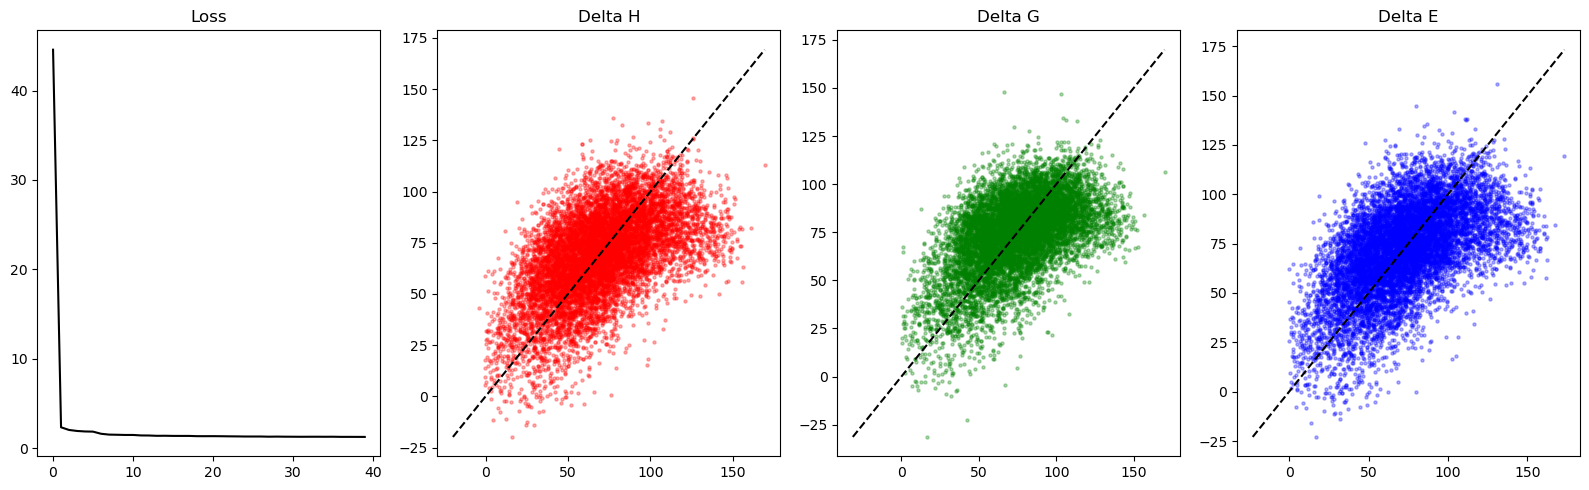

In [20]:
if __name__ == "__main__":
    import os
    base_dir = r"C:\Users\yeseo\OneDrive\OneDrive - personal\서류&파일\University of Seoul\연구\Code"
    MY_H5_PATH = os.path.join(base_dir, "RGD1_CHNO.h5")
    
    if os.path.exists(MY_H5_PATH):
        hist, r_E3, p_E3 = train(MY_H5_PATH, epochs=40, limit=10000)
        
        if hist:
            plt.figure(figsize=(16, 5))
            plt.subplot(1, 4, 1); plt.plot(hist['loss'], 'k-'); plt.title("Loss")
            titles, colors = ["Delta H", "Delta G", "Delta E"], ['r', 'g', 'b']
            keys = ['H', 'G', 'E']
            for i, k in enumerate(keys):
                plt.subplot(1, 4, i+2)
                plt.scatter(r_E3[k], p_E3[k], alpha=0.3, color=colors[i], s=5)
                mx = max(max(r_E3[k]), max(p_E3[k]))
                mn = min(min(r_E3[k]), min(p_E3[k]))
                plt.plot([mn, mx], [mn, mx], 'k--')
                plt.title(titles[i])
            plt.tight_layout()
            plt.show()
    else:
        print("파일을 찾을 수 없습니다.")

In [21]:
import numpy as np

def print_evaluation_report(real_dict, pred_dict):
    """
    학습 결과(정답 vs 예측)를 받아서 MAE, RMSE, R2, MSE를 계산하고 출력합니다.
    """
    print("\n" + "="*75)
    print(f"   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)")
    print("="*75)
    
    # 헤더 출력
    header = f"{'Energy Type':<15} | {'MAE':<10} | {'RMSE':<10} | {'MSE':<10} | {'R² Score':<10}"
    print(header)
    print("-" * 75)

    # H, G, E 각각에 대해 계산
    metrics = {}
    for key in ['H', 'G', 'E']:
        y_true = np.array(real_dict[key])
        y_pred = np.array(pred_dict[key])
        
        # 1. MAE (Mean Absolute Error)
        mae = np.mean(np.abs(y_true - y_pred))
        
        # 2. MSE (Mean Squared Error)
        mse = np.mean((y_true - y_pred)**2)
        
        # 3. RMSE (Root Mean Squared Error)
        rmse = np.sqrt(mse)
        
        # 4. R2 Score (Coefficient of Determination)
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        r2 = 1 - (ss_res / (ss_tot + 1e-8)) # 0으로 나누기 방지
        
        # 결과 저장
        metrics[key] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

        # 행 출력
        label = f"Delta {key} (Δ{key})"
        print(f"{label:<15} | {mae:<10.4f} | {rmse:<10.4f} | {mse:<10.4f} | {r2:<10.4f}")

    print("="*75)
    
    # [화학적 해석]
    # 화학적 정확도(Chemical Accuracy)는 보통 1 kcal/mol 이내를 말합니다.
    avg_mae = np.mean([metrics[k]['MAE'] for k in ['H', 'G', 'E']])
    print(f"⭐ Average MAE: {avg_mae:.4f} kcal/mol")
    
    if avg_mae < 2.5:
        print("✅ 모델이 물리 법칙(BEP, Hammond, Pauling)을 매우 잘 학습했습니다!")
        print("   (일반적인 DFT 계산 오차가 2~3 kcal/mol 수준임을 감안하면 훌륭합니다.)")
    elif avg_mae < 5.0:
        print("⚠️ 학습이 잘 되었으나, 일부 복잡한 반응에서 오차가 있습니다.")
    else:
        print("❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.")
    print("="*75 + "\n")

# ==============================================================================
# [실행 방법] main 블록 안에서 train()이 끝난 후 호출하세요
# ==============================================================================
if __name__ == "__main__":
    # 위에서 이미 train을 실행해서 r_E3, p_E3가 있다고 가정합니다.
    # 만약 변수가 메모리에 없다면 다시 학습을 돌려야 합니다.
    
    if 'r_E3' in locals() and 'p_E3' in locals():
        print_evaluation_report(r_E3, p_E3)
    else:
        print("먼저 train() 함수를 실행하여 r_E3, p_E3 변수를 생성해주세요.")


   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)
Energy Type     | MAE        | RMSE       | MSE        | R² Score  
---------------------------------------------------------------------------
Delta H (ΔH)    | 19.1205    | 24.1683    | 584.1074   | 0.2654    
Delta G (ΔG)    | 18.5751    | 23.2973    | 542.7620   | 0.2305    
Delta E (ΔE)    | 19.8430    | 25.1102    | 630.5222   | 0.2652    
⭐ Average MAE: 19.1796 kcal/mol
❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.

